In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Alfa Romeo.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_145,Seri_146,Seri_147,...,Model_2.0 TS Distinctive,Model_2.0 TS Executive,Model_2.0 TS Selespeed,Model_2.0 Turbo,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,252250,2004,165,1970,250000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,480000,2011,105,1598,185000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,375000,2009,155,1368,151000,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,226000,2004,120,1598,271500,NaN,NaN,0,0,1,...,0,0,0,0,0,0,1,1,0,0
4,439000,2012,105,1598,280000,8.0,0.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_12512\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,61560.0389,6.569796e+09,81054.276398,60677.566612


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': [10000],
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 13:43:07,405] A new study created in memory with name: no-name-ea5f1bfe-7cb8-4c69-a09e-9db01c3d32a8
[I 2023-10-08 13:43:07,542] Trial 1 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.15888286183901298, 'max_depth': 3, 'min_child_weight': 91}. Best is trial 1 with value: 411951.05434637755.
[I 2023-10-08 13:43:07,542] Trial 3 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.01914453470214681, 'max_depth': 14, 'min_child_weight': 243}. Best is trial 1 with value: 411951.05434637755.
[I 2023-10-08 13:43:07,542] Trial 0 finished with value: 391594.7822485954 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01935861064608732, 'max_depth': 15, 'min_child_weight': 64}. Best is trial 0 with value: 391594.7822485954.
[I 2023-10-08 13:43:07,552] Trial 2 finished with value: 200813.83534190143 and parameters: {'co

[I 2023-10-08 13:43:08,663] Trial 31 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.09123718254273308, 'max_depth': 10, 'min_child_weight': 276}. Best is trial 21 with value: 67168.61006810797.
[I 2023-10-08 13:43:08,676] Trial 30 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.08375300736473568, 'max_depth': 10, 'min_child_weight': 272}. Best is trial 21 with value: 67168.61006810797.
[I 2023-10-08 13:43:08,832] Trial 32 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.09543572564465397, 'max_depth': 10, 'min_child_weight': 70}. Best is trial 21 with value: 67168.61006810797.
[I 2023-10-08 13:43:08,854] Trial 35 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.16722329941882771, 'max_depth': 10, 'min_child_

[I 2023-10-08 13:43:10,231] Trial 60 finished with value: 67839.96354456584 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4628625092069461, 'max_depth': 14, 'min_child_weight': 28}. Best is trial 49 with value: 63455.4119206132.
[I 2023-10-08 13:43:10,283] Trial 61 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.14106631883462734, 'max_depth': 8, 'min_child_weight': 96}. Best is trial 49 with value: 63455.4119206132.
[I 2023-10-08 13:43:10,408] Trial 63 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.15682653584803105, 'max_depth': 9, 'min_child_weight': 91}. Best is trial 49 with value: 63455.4119206132.
[I 2023-10-08 13:43:10,429] Trial 62 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.1488524715183357, 'max_depth': 9, 'min_child_weight': 93

[I 2023-10-08 13:43:12,003] Trial 89 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.29332373139472667, 'max_depth': 15, 'min_child_weight': 189}. Best is trial 49 with value: 63455.4119206132.
[I 2023-10-08 13:43:12,117] Trial 92 finished with value: 64234.543943486 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.3068279490642674, 'max_depth': 15, 'min_child_weight': 25}. Best is trial 49 with value: 63455.4119206132.
[I 2023-10-08 13:43:12,127] Trial 91 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.28951991795547166, 'max_depth': 15, 'min_child_weight': 299}. Best is trial 49 with value: 63455.4119206132.
[I 2023-10-08 13:43:12,363] Trial 93 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.28885113996468514, 'max_depth': 13, 'min_child_weight'

[I 2023-10-08 13:43:14,208] Trial 121 finished with value: 67502.27421012725 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.3279012619212673, 'max_depth': 6, 'min_child_weight': 20}. Best is trial 98 with value: 62160.61616054312.
[I 2023-10-08 13:43:14,208] Trial 122 finished with value: 77858.10868218332 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.34621879512251374, 'max_depth': 6, 'min_child_weight': 18}. Best is trial 98 with value: 62160.61616054312.
[I 2023-10-08 13:43:14,246] Trial 120 finished with value: 76420.75216737922 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.3265427581940948, 'max_depth': 8, 'min_child_weight': 18}. Best is trial 98 with value: 62160.61616054312.
[I 2023-10-08 13:43:14,391] Trial 123 finished with value: 63346.58998515562 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3269052849238353, 'max_depth': 6, 'min_child_weight': 

[I 2023-10-08 13:43:16,343] Trial 150 finished with value: 86678.46107842542 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.4201804454603377, 'max_depth': 14, 'min_child_weight': 33}. Best is trial 98 with value: 62160.61616054312.
[I 2023-10-08 13:43:16,417] Trial 151 finished with value: 96565.97878664195 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.4214628814352534, 'max_depth': 14, 'min_child_weight': 34}. Best is trial 98 with value: 62160.61616054312.
[I 2023-10-08 13:43:16,464] Trial 154 finished with value: 96559.2963061144 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.42183040291026047, 'max_depth': 14, 'min_child_weight': 34}. Best is trial 98 with value: 62160.61616054312.
[I 2023-10-08 13:43:16,479] Trial 152 finished with value: 86648.94485215406 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.4174556353896921, 'max_depth': 14, 'min_child_weight

[I 2023-10-08 13:43:18,542] Trial 180 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.35374915567439974, 'max_depth': 11, 'min_child_weight': 121}. Best is trial 174 with value: 59785.63996012054.
[I 2023-10-08 13:43:18,596] Trial 181 finished with value: 69166.11536165171 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3520330903191205, 'max_depth': 11, 'min_child_weight': 11}. Best is trial 174 with value: 59785.63996012054.
[I 2023-10-08 13:43:18,609] Trial 182 finished with value: 61775.78040766985 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.3722050335740513, 'max_depth': 11, 'min_child_weight': 9}. Best is trial 174 with value: 59785.63996012054.
[I 2023-10-08 13:43:18,680] Trial 184 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.004670064383051644, 'max_depth': 11, 'min_chil

[I 2023-10-08 13:43:20,627] Trial 210 finished with value: 61213.877680358244 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.3935481787960054, 'max_depth': 7, 'min_child_weight': 23}. Best is trial 174 with value: 59785.63996012054.
[I 2023-10-08 13:43:20,748] Trial 211 finished with value: 63232.73431942397 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.39517823695446563, 'max_depth': 7, 'min_child_weight': 22}. Best is trial 174 with value: 59785.63996012054.
[I 2023-10-08 13:43:20,898] Trial 212 finished with value: 76270.75316132793 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.4209481498255883, 'max_depth': 8, 'min_child_weight': 30}. Best is trial 174 with value: 59785.63996012054.
[I 2023-10-08 13:43:20,898] Trial 213 finished with value: 76293.95013298257 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.42422491739655704, 'max_depth': 7, 'min_child_weig

[I 2023-10-08 13:43:23,036] Trial 239 finished with value: 73935.9845393066 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.27838703707215157, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 174 with value: 59785.63996012054.
[I 2023-10-08 13:43:23,086] Trial 240 finished with value: 74482.81516345798 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.2727566863003862, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 174 with value: 59785.63996012054.
[I 2023-10-08 13:43:23,212] Trial 242 finished with value: 68512.1724030584 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4406952535544456, 'max_depth': 7, 'min_child_weight': 4}. Best is trial 174 with value: 59785.63996012054.
[I 2023-10-08 13:43:23,332] Trial 243 finished with value: 83463.6103025652 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.44724637736410877, 'max_depth': 7, 'min_child_weight': 

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 59785.6400
Best params:
	colsample_bytree: 0.9
	subsample: 0.8
	learning_rate: 0.33877631441662576
	max_depth: 12
	min_child_weight: 24


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 86569.02909892642, 'MSE': 3630868103.439506, 'RMSE': 60256.68513484214, 'MAE': 46848.62438322369}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.8830125702365997

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.6571058093141716

In [16]:
marka_model = joblib.dump(final_model, "Alfa Romeo.pkl")

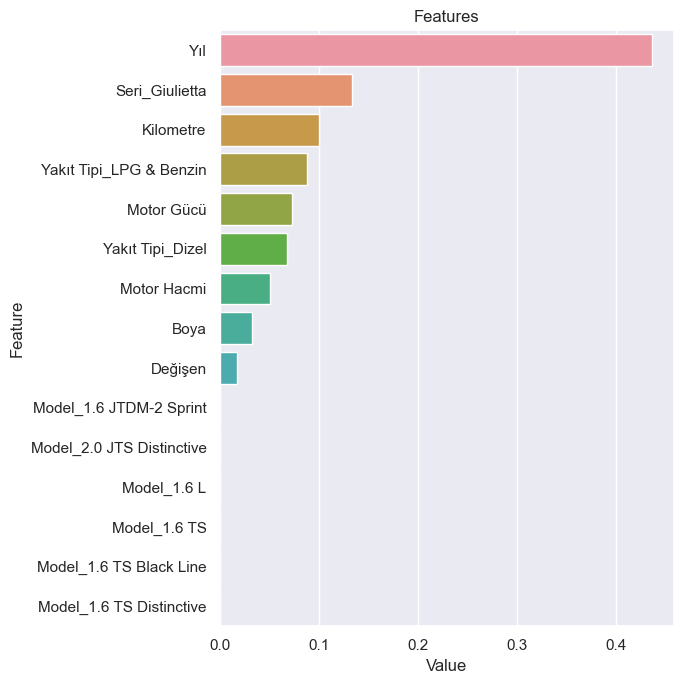

In [18]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)